In [191]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
import torch
import outpaint
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
importlib.reload(outpaint)

#filename = "/home/tim/devel/nnfs/outputs/alex-outpaint-128-20230210-013959/epoch01591-step615872.torch"
filename = "/home/tim/devel/nnfs/outputs/alex-outpaint-128-20230210-163842/epoch00187-step072711.torch"
net = torch.load(filename)

dataset = torchvision.datasets.ImageFolder(
    root="alex-outpaint-128",
    transform=transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

chunk_size = 16
batch_size = 8

#dataloader = outpaint.RightChunkDataLoader(dataset, chunk_size, batch_size, True)
dataloader = DataLoader(dataset, batch_size, True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 128, 128])
combined torch.Size([3, 128, 80])
col 0 inputs torch.Size([8, 3, 16, 16]) flat torch.Size([3, 128, 16])
col 1 inputs torch.Size([8, 3, 16, 16]) flat torch.Size([3, 128, 16])
col 2 inputs torch.Size([8, 3, 16, 16]) flat torch.Size([3, 128, 16])
col 3 inputs torch.Size([8, 3, 16, 16]) flat torch.Size([3, 128, 16])


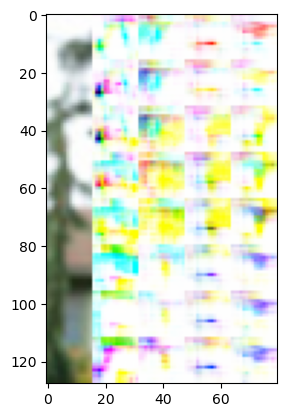

In [232]:
fullsizes, _ = next(iter(dataloader))
print(fullsizes.shape)
height = fullsizes.shape[2]
batch = int(height / chunk_size)

first = fullsizes[:, :, :, :chunk_size][0]                        # -> 3, H, 16
inputs = torch.reshape(first, (batch, 3, chunk_size, chunk_size)) # -> B, 3, 16, 16
inputs = inputs.to("cuda")

num_cols = 4
combined = torch.zeros((3, height, chunk_size * (num_cols + 1)))
combined[:, :, 0:chunk_size] = first
print(f"combined {combined.shape}")
for col in range(num_cols):
    xstart = chunk_size * (col + 1)
    xend = xstart + chunk_size
    outputs = net(inputs)
    flat = outputs.reshape((3, height, chunk_size))
    print(f"col {col} inputs {inputs.shape} flat {flat.shape}")
    combined[:, :, xstart:xend] = flat
    inputs = outputs

combined = combined.detach().cpu()
plt.imshow(np.transpose(combined, (1, 2, 0)))


In [80]:
outputs.reshape(8, -1).max(dim=1)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 0.9989, 1.0000, 1.0000, 1.0000, 1.0000]),
indices=tensor([107,  11,   6,  64, 100, 171,  55,   1]))